In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, ttest_rel, wilcoxon

In [2]:
data_type = 'elec_price'
data_name = 'priceMT'
control = ['AK', 'AL', 'AR', 'AZ', 'CO', 'DE', 'ID', 'FL', 'GA', 'HI', 'IA', 'IN', 'KS', 'KY', 'LA', 
            'ME', 'MN', 'MI', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NM', 'NV', 'OH', 'OK', 'OR',
            'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
seq_len = 12
pred_len = 24
elec_price_results_path = os.path.join(os.getcwd(),'elec_price/')
data_root_path = base_dir = os.path.join(os.getcwd(),'../')

In [3]:
#Load DeepProbCP metrics
deep_met_path = os.path.join(elec_price_results_path, 'DeepProbCP/', 'metrics/')
metrics_cp = {}
control_metrics = pd.read_csv(deep_met_path +'mean_median_control_' + data_name + '_' + 'LSTMcell_cocob_12_24_without_stl_decomposition.txt', 
                                          header = None, sep = ' ')
deepprob_smape = np.round((control_metrics.iloc[0,1]) ,3)
deepprob_mase = np.round((control_metrics.iloc[1,1]),3)


In [4]:
# Load TSMixer metrics
tsmixer_met_path = os.path.join(elec_price_results_path,'tsmixer/metrics/')
control_metrics = pd.read_csv(tsmixer_met_path+ 'TSMixer' + '_' + data_type + '_'+ data_name + '_MS_sl12_pl24' + '_metrics_control.csv')
tsmixer_smape = np.round((control_metrics['smape'].values[0]) ,3)
tsmixer_mase = np.round((control_metrics['mase'].values[0]) ,3)

In [5]:
# Load ASCM metrics
ascm_met_path = os.path.join(elec_price_results_path,'ascm/metrics/')
control_metrics= pd.read_csv(ascm_met_path+ data_name + '_metrics_control.txt', header = None, sep = ' ')
ascm_mase = np.round((control_metrics.iloc[0,1]),3)
ascm_smape = np.round((control_metrics.iloc[1,1]),3)


# Load CausalArima metrics
causar_met_path = os.path.join(elec_price_results_path,'CausalArima/metrics/')
control_metrics = pd.read_csv(causar_met_path+ data_name + '_metrics_control.txt', header = None, sep = ' ')
causar_mase = np.round((control_metrics.iloc[0,1]),3)
causar_smape = np.round((control_metrics.iloc[1,1]),3)



In [6]:
df_metrics = pd.DataFrame(index = ['smape' , 'mase'],columns=['TSMixer','DeepProbCP','ASCM','CausalArima'])
df_metrics['TSMixer'] = [tsmixer_smape,tsmixer_mase]
df_metrics['DeepProbCP'] = [deepprob_smape,deepprob_mase]
df_metrics['ASCM'] = [ascm_smape,ascm_mase]
df_metrics['CausalArima'] = [causar_smape,causar_mase]

df_metrics

,TSMixer,DeepProbCP,ASCM,CausalArima
smape,0.052,0.035,0.061,0.041
mase,2.191,1.341,2.719,1.852


## ATT


In [7]:
df_raw = pd.read_csv(data_root_path+ "data/" + data_type + "/" + data_name + "_" + \
                                  "full_table" + ".csv")
trues = df_raw.iloc[len(df_raw)- pred_len:,:]
trues_treated = np.array(df_raw.loc[len(df_raw)- pred_len:,~df_raw.columns.isin(control)])        


In [8]:
#DeepProbCP
deep_preds_path = os.path.join(elec_price_results_path ,'DeepProbCP/processed_ensemble_forecasts/')
preds = pd.read_csv(deep_preds_path + data_name + '_LSTMcell_cocob_12_24_without_stl_decomposition_0.5.txt', 
                                          header = None, sep = ',').T
preds.columns = df_raw.columns.to_list()
preds_treated = np.array(preds.loc[:,~preds.columns.isin(control)])


deepprob_att = np.mean(trues_treated-preds_treated)

In [9]:
#TSMixer
tsmixer_preds_path = os.path.join(elec_price_results_path ,'tsmixer/forecasts/')
preds = pd.read_csv(tsmixer_preds_path+ 'TSMixer' + '_' + data_type + '_'+ data_name + '_MS_sl12_pl24' + '_preds.csv').iloc[:,1:51]
preds_treated = np.array(preds.loc[:,~preds.columns.isin(control)])
tsmixer_att = np.mean(trues_treated-preds_treated)

In [10]:
#ASCM
ascm_preds_path = os.path.join(elec_price_results_path,'ascm/forecasts/')
preds = pd.read_csv(ascm_preds_path+ data_name + '_predictions.csv')
preds_treated = np.array(preds.loc[len(preds) - pred_len:,~preds.columns.isin(control)])
ascm_att = np.mean(trues_treated-preds_treated)

#CausalArine
causar_preds_path = os.path.join(elec_price_results_path,'CausalArima/forecasts/')
preds = pd.read_csv(causar_preds_path+ data_name + '_predictions.csv')
preds_treated = np.array(preds.loc[:,~preds.columns.isin(control)])
causar_att = np.mean(trues_treated-preds_treated)

In [11]:
df_att = pd.DataFrame(index = ['ATT'],columns=['TSMixer','DeepProbCP','ASCM','CausalArima'])
df_att['TSMixer'] = [deepprob_att]
df_att['DeepProbCP'] = [tsmixer_att]
df_att['ASCM'] = [ascm_att]
df_att['CausalArima'] = [causar_att]

df_att

,TSMixer,DeepProbCP,ASCM,CausalArima
ATT,-0.795349,-0.859369,-0.441781,-1.064241


### Placebo Tests

In [12]:
df_raw = pd.read_csv(data_root_path+ "data/" + data_type + "/" + data_name + "_" + \
                                  "full_table" + ".csv")
trues = df_raw.iloc[len(df_raw)- pred_len:,:]



In [215]:
def placebo_test(trues, model):
    data_type = 'elec_price'
    data_name = 'priceMT'
    control = ['AK', 'AL', 'AR', 'AZ', 'CO', 'DE', 'ID', 'FL', 'GA', 'HI', 'IA', 'IN', 'KS', 'KY', 'LA', 
            'ME', 'MN', 'MI', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NM', 'NV', 'OH', 'OK', 'OR',
            'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
    seq_len = 12
    pred_len = 24
    elec_price_results_path = os.path.join(os.getcwd(),'elec_price/')
    data_root_path = base_dir = os.path.join(os.getcwd(),'../')    

    #true treated averages per time step
    trues_treated = np.array(trues.loc[:,~df_raw.columns.isin(control)])  
    trues_treated_averages =  trues_treated.mean(axis = 1)   

    #true control averages per time step
    trues_control = np.array(trues.loc[:,control])      
    trues_control_averages =  trues_control.mean(axis = 1)

    #DeepProbCP
    if model=='DeepProbCP':
        deep_preds_path = os.path.join(elec_price_results_path ,'DeepProbCP/processed_ensemble_forecasts/')
        preds = pd.read_csv(deep_preds_path + data_name + '_LSTMcell_cocob_12_24_without_stl_decomposition_0.5.txt', 
                                          header = None, sep = ',').T
        preds.columns = df_raw.columns.to_list()
    elif model=='TSMixer':
        tsmixer_preds_path = os.path.join(elec_price_results_path ,'tsmixer/forecasts/')
        preds = pd.read_csv(tsmixer_preds_path+ 'TSMixer' + '_' + data_type + '_'+ data_name + '_MS_sl12_pl24' + '_preds.csv').iloc[:,1:51]

    elif model=='ascm':
        ascm_preds_path = os.path.join(elec_price_results_path,'ascm/forecasts/')
        preds = pd.read_csv(ascm_preds_path+ data_name + '_predictions.csv')
        preds = preds.iloc[len(preds) - pred_len:,:]
    elif model=='CausalArima':
        causar_preds_path = os.path.join(elec_price_results_path,'CausalArima/forecasts/')
        preds = pd.read_csv(causar_preds_path+ data_name + '_predictions.csv')


    #predicted treated averages per time step
    preds_treated = np.array(preds.loc[:,~preds.columns.isin(control)]).round(2)
    preds_treated_averages = preds_treated.mean(axis=1)

    #predicted control averages per time step
    preds_control = np.array(preds.loc[:,control]).round(2)
    preds_control_averages = preds_control.mean(axis=1)

    #treated
    diff_I = pd.DataFrame(preds_treated_averages,columns = ['predicted'])
    diff_I['y'] = trues_treated_averages
    diff_I['ab_diff'] = abs(diff_I['predicted'] - diff_I['y'])
    diff_I['ab_sum_av'] = (abs(diff_I['predicted']) + abs(diff_I['y'])) / 2
    diff_I['ab_diff_propY'] = diff_I['ab_diff'] / diff_I['y']
    diff_I['ab_diff_propT'] = diff_I['ab_diff'] / diff_I['predicted']
    diff_I['ab_diff_propYF'] = diff_I['ab_diff'] / diff_I['ab_sum_av']

    #control
    diff_NI = pd.DataFrame(preds_control_averages,columns = ['predicted'])
    diff_NI['y'] = trues_control_averages
    diff_NI['ab_diff'] = abs(diff_NI['predicted'] - diff_NI['y'])
    diff_NI['ab_sum_av'] = (abs(diff_NI['predicted']) + abs(diff_NI['y'])) / 2
    diff_NI['ab_diff_propY'] = diff_NI['ab_diff'] / diff_NI['y']
    diff_NI['ab_diff_propT'] = diff_NI['ab_diff'] / diff_NI['predicted']
    diff_NI['ab_diff_propYF'] = diff_NI['ab_diff'] / diff_NI['ab_sum_av']

    # 2.Mean significance test for relative differences
    #diff_I_vec = diff_I['ab_diff_propT'].values * 100
    #diff_NI_vec = diff_NI['ab_diff_propT'].values * 100
    diff_I_vec = diff_I['ab_diff'].values
    diff_NI_vec = diff_NI['ab_diff'].values
    diff_for_test = np.around( diff_I_vec - diff_NI_vec ,3)

    mean_treated = diff_I_vec.mean()
    median_treated = pd.Series(diff_I_vec).median()

    mean_control = diff_NI_vec.mean()
    median_control = pd.Series(diff_NI_vec).median()

    ### 3. TESTS FOR DIFFERENCE OF MEANS - Wilcoxon signed-rank exact test 
    #### if p-value < 0.05, the difference between means is significant. In other words, the means are statistically different.

    wilcoxon_test_result = wilcoxon(diff_for_test) 

    return (mean_treated , mean_control, wilcoxon_test_result.pvalue)

In [216]:
#DeepProbCP
mean_treated, mean_control, test_result = placebo_test(trues, model = 'DeepProbCP')

print ('DeepProbCP results:' '\nmean_treated: ', mean_treated , '\nmean_control: ', mean_control,
        '\nWilcoxon test p-value: ', test_result)

DeepProbCP results:
mean_treated:  0.7950925925925924 
mean_control:  0.07343495934959321 
Wilcoxon test p-value:  1.1920928955078125e-07


In [217]:
#TSMixer
mean_treated, mean_control, test_result= placebo_test(trues, model = 'TSMixer')

print ('TSMixer results:' '\nmean_treated: ', mean_treated , '\nmean_control: ', mean_control,
        '\nWilcoxon test p-value: ', test_result)

TSMixer results:
mean_treated:  0.8633796296296298 
mean_control:  0.19827235772357685 
Wilcoxon test p-value:  2.9802322387695312e-06


In [218]:
#ASCM
mean_treated , mean_control, test_result = placebo_test(trues, model = 'ascm')

print ('ASCM results:' '\nmean_treated: ', mean_treated , '\nmean_control: ', mean_control,
        '\nWilcoxon test p-value: ', test_result)

ASCM results:
mean_treated:  0.4674537037037037 
mean_control:  0.0003861788617888588 
Wilcoxon test p-value:  1.1920928955078125e-07


In [219]:
#Causal Arima
mean_treated , mean_control, test_result = placebo_test(trues, model = 'CausalArima')

print ('Causal Arima results:' '\nmean_treated: ', mean_treated , '\nmean_control: ', mean_control,
        '\nWilcoxon test p-value: ', test_result)

Causal Arima results:
mean_treated:  1.0636574074074074 
mean_control:  0.07635162601626085 
Wilcoxon test p-value:  1.1920928955078125e-07


---


### Plotting

In [ ]:
data_type = 'elec_price'
data_name = 'priceMT'
control = ['AK', 'AL', 'AR', 'AZ', 'CO', 'DE', 'ID', 'FL', 'GA', 'HI', 'IA', 'IN', 'KS', 'KY', 'LA', 
            'ME', 'MN', 'MI', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NM', 'NV', 'OH', 'OK', 'OR',
            'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
seq_len = 12
pred_len = 24
elec_price_results_path = os.path.join(os.getcwd(),'elec_price/')
data_root_path = base_dir = os.path.join(os.getcwd(),'../')    

dates = pd.date_range(start="1990-01", periods=120, freq="M").to_period("M") 
dates_postint = dates[96:]

df_raw = pd.read_csv(data_root_path+ "data/" + data_type + "/" + data_name + "_" + \
                                  "full_table" + ".csv")
treated_true = df_raw.loc[:,~df_raw.columns.isin(control)]
treated_true.set_index(dates, inplace = True)
treated_true.index = treated_true.index.to_timestamp()
treated_true = treated_true.mean(axis=1)
#treated_pre_int = treated.iloc[:len(treated)-pred_len,:].mean(axis = 1)
#treated_post_int = treated.iloc[len(treated)-pred_len:,:].mean(axis = 1)

control_true = df_raw.loc[:,control]
control_true.set_index(dates, inplace = True)
control_true.index = control_true.index.to_timestamp()
control_true = control_true.mean(axis=1)
#control_pre_int = control.iloc[:len(control)-pred_len,:].mean(axis = 1)
#control_post_int = control.iloc[len(control)-pred_len:,:].mean(axis = 1)


In [20]:
#DeepProbCP
deep_preds_path = os.path.join(elec_price_results_path ,'DeepProbCP/processed_ensemble_forecasts/')
deepprobcp_preds = pd.read_csv(deep_preds_path + data_name + '_LSTMcell_cocob_12_24_without_stl_decomposition_0.5.txt', 
                                          header = None, sep = ',').T
deepprobcp_preds.columns = df_raw.columns.to_list()
deepprobcp_preds.set_index(dates_postint, inplace = True)
deepprobcp_preds.index = deepprobcp_preds.index.to_timestamp()
deepprobcp_preds_treated = deepprobcp_preds.loc[:,~deepprobcp_preds.columns.isin(control)].mean(axis = 1)
deepprobcp_preds_control = deepprobcp_preds.loc[:,control].mean(axis = 1)

#TSMixer
tsmixer_preds_path = os.path.join(elec_price_results_path ,'tsmixer/forecasts/')
tsmixer_preds = pd.read_csv(tsmixer_preds_path+ 'TSMixer' + '_' + data_type + '_'+ data_name + '_MS_sl12_pl24' + '_preds.csv').iloc[:,1:51]
tsmixer_preds.set_index(dates_postint, inplace = True)
tsmixer_preds.index = tsmixer_preds.index.to_timestamp()
tsmixer_preds_treated = tsmixer_preds.loc[:,~tsmixer_preds.columns.isin(control)].mean(axis = 1)
tsmixer_preds_control = tsmixer_preds.loc[:,control].mean(axis = 1)

#ASCM
ascm_preds_path = os.path.join(elec_price_results_path,'ascm/forecasts/')
ascm_preds = pd.read_csv(ascm_preds_path+ data_name + '_predictions.csv')
ascm_preds = ascm_preds.iloc[len(ascm_preds) - pred_len:,:]
ascm_preds.set_index(dates_postint, inplace = True)
ascm_preds.index = ascm_preds.index.to_timestamp()
ascm_preds_treated = ascm_preds.loc[:,~ascm_preds.columns.isin(control)].mean(axis = 1)
ascm_preds_control = ascm_preds.loc[:,control].mean(axis = 1)

#Causal Arima
causar_preds_path = os.path.join(elec_price_results_path,'CausalArima/forecasts/')
causar_preds = pd.read_csv(causar_preds_path+ data_name + '_predictions.csv')
causar_preds.set_index(dates_postint, inplace = True)
causar_preds.index = causar_preds.index.to_timestamp()
causar_preds_treated = causar_preds.loc[:,~causar_preds.columns.isin(control)].mean(axis = 1)
causar_preds_control = causar_preds.loc[:,control].mean(axis = 1)

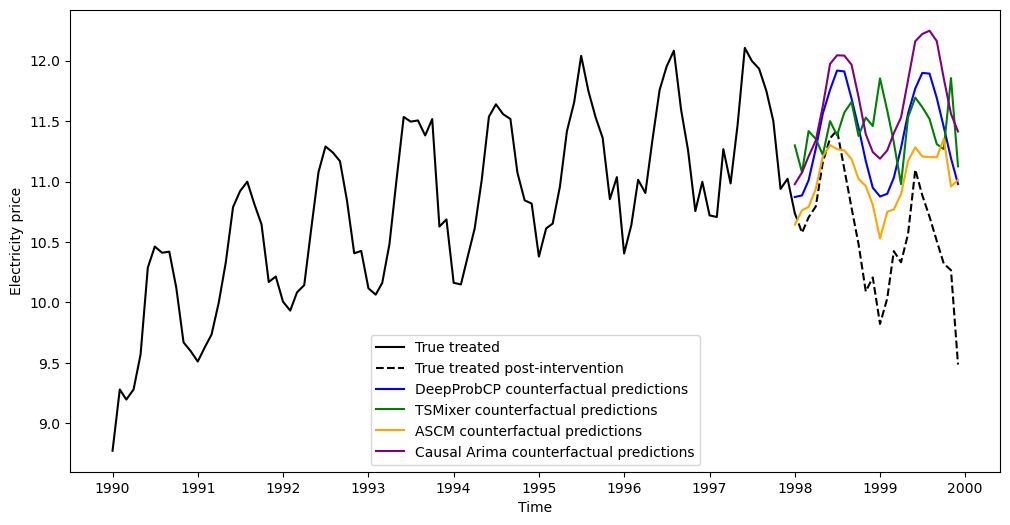

In [21]:
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(treated_true[:len(treated_true)-pred_len +1,], label = 'True treated', color = 'black')
ax.plot(treated_true[len(treated_true)-pred_len:,], color = 'black', linestyle = '--', label = 'True treated post-intervention')
ax.plot(deepprobcp_preds_treated, label = 'DeepProbCP counterfactual predictions', color = 'blue',)

ax.plot(tsmixer_preds_treated, label = 'TSMixer counterfactual predictions', color = 'green')

ax.plot(ascm_preds_treated, label = 'ASCM counterfactual predictions', color = 'orange')

ax.plot(causar_preds_treated, label = 'Causal Arima counterfactual predictions', color = 'purple')

ax.set_xlabel('Time')
ax.set_ylabel('Electricity price')
ax.legend()

plt.show()


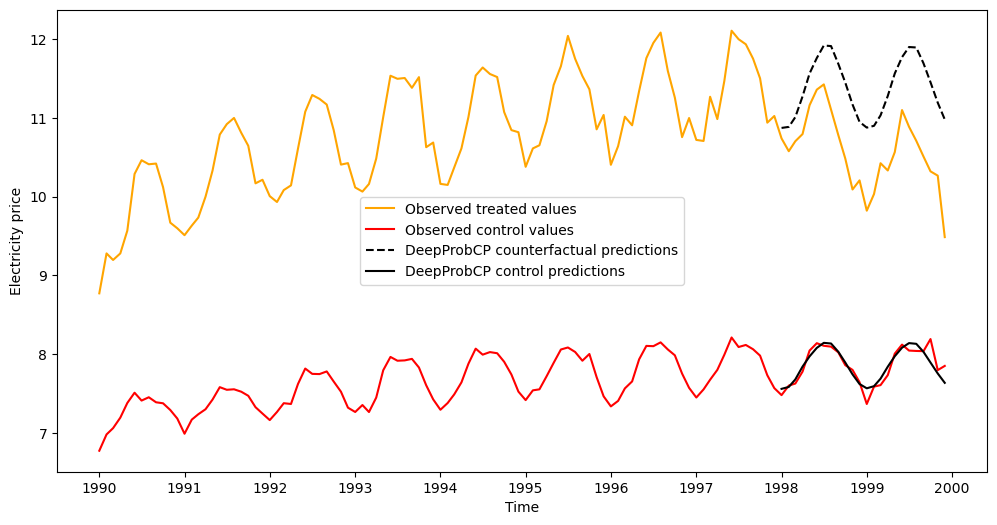

In [22]:
fig, ax = plt.subplots(figsize = (12,6))

ax.plot(treated_true, label = 'Observed treated values', color = 'orange')
ax.plot(control_true, label = 'Observed control values', color = 'red')


ax.plot(deepprobcp_preds_treated, label = 'DeepProbCP counterfactual predictions', color = 'black', linestyle = '--')
ax.plot(deepprobcp_preds_control, label = 'DeepProbCP control predictions', color = 'black')

ax.set_xlabel('Time')
ax.set_ylabel('Electricity price')
ax.legend()

plt.show()